# Range Calculation for FMCW

To calculate each distance point, you need first to calculate the frequencies.  
I use for this task a helper function called [numpy.fft.rfftfreq(x)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfftfreq.html#numpy.fft.rfftfreq).  
But you can also solve this calculation very easy with your own helper function.

In [1]:
def rfftfreq(window_length, inverse_sampling_rate):
    """
    This function returns a array with corresponding frquencies.
    The implementation is based on this function:
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfftfreq.html#numpy.fft.rfftfreq
    """
    results = [] # list with results
    if window_length % 2 == 0: # even
        end = window_length // 2 + 1 # integer division
    else: # odd
        end = window_length // 2 # integer division
    for n in range(0, end):
        freq = n / (inverse_sampling_rate * window_length) # real division
        results.append(freq)
    return results

# Result
The retuned array has the same size as the rfft (real fft).  
The first frequency is 0 Hz, which is the DC part of the signal.

In [2]:
import math
import numpy as np

In [3]:
def compare(arr1, arr2):
    """
    Helper function to compare two different arrays.
    Just testing for corectness.
    """
    for a1, a2 in zip(arr1, arr2):
        if not math.isclose(a1, a2):
            print('Not equal')
            break
    else:
        print('Both arrays are equal')

In [4]:
SAMPLING_RATE = 100_000
INVERSE_SAMPLING_RATE = 1.0 / SAMPLING_RATE
WINDOW_SIZE = 64

numpy_implementation = np.fft.rfftfreq(WINDOW_SIZE, INVERSE_SAMPLING_RATE)
own_implementation = rfftfreq(WINDOW_SIZE, INVERSE_SAMPLING_RATE)

compare(numpy_implementation, own_implementation)

Both arrays are equal


## Simpler solution
A simpler solution is, just to calculate the second value, which is the first frequncy.

In [5]:
def get_frequency_step(window_length, inverse_sampling_rate):
    """
    This function returns the sceond frequency. The first frequency is 0Hz.
    All frequencies afterwards are depending on the window_length and sampling rate
    """
    return 1.0 / (inverse_sampling_rate * window_length)

In [6]:
get_frequency_step(WINDOW_SIZE, INVERSE_SAMPLING_RATE)

1562.4999999999998

In [7]:
own_implementation[1] # frqeuency from the first function

1562.4999999999998

# Frequencies > Distance
The next step is calculating the distances for each point.
\begin{align}
{r} & = {{c} \over {2}} \cdot {\Delta t} =  {{c} \over {2}} \cdot {{\Delta f} \over {df / dt}} \\
\end{align}

* r = Distance in meter  
* c = speed of light
* Δf = measured frequency
* df = frequency change of chirp
* dt = time of frequency change of chirp

![fmcw principle](https://upload.wikimedia.org/wikipedia/commons/4/4b/Fmcw_prinziple.png)

## Implementation
The implementation 

In [8]:
C = 299792458 # m/s
SAMPLING_RATE = 122880
# max with 2 channels is 150kS/s
# 122880 because you can divide it by 4096, 2048, ..., 64
WINDOW_SIZE = 64
BANDWIDTH = 180e6 # 180MHz
# depends on chirp. 1V - 10V Chirp == 180MHz

DELTA_T = WINDOW_SIZE / SAMPLING_RATE # 640 us

def calculate_distance(measured_frequency, delta_f, delta_t):
    return (C / 2.0) * measured_frequency / (delta_f / delta_t)

# Calculate an example
1562 Hz is the calculated frequency from the example before.

In [9]:
calculate_distance(1562, BANDWIDTH, DELTA_T)

0.6774823775983796

This result means, that the incrasing distance is 0.677m for each step.  
To save time, you can reuse this created array, because it changes only, when  
you change the settings (sample rate, bandwidth, window_size).

# Combination of get_frequency_step and calculate_distance

In [10]:
def get_distance_step(measured_frequency, delta_f, delta_t, window_length, inverse_sampling_rate):
    fD = 1.0 / (inverse_sampling_rate * window_length)
    r = (C / 2.0) * measured_frequency / (delta_f / delta_t) # this is the distance step
    fft_len = window_length // 2 + 1
    distances = []
    for n in range(fft_len):
        distances.append(n * r)
    return distances

In [11]:
C = 299792458 # m/s
SAMPLING_RATE = 122880
INVERSE_SAMPLING_RATE = 1.0 / SAMPLING_RATE
WINDOW_SIZE = 64
BANDWIDTH = 180e6 # 180 MHz
DELTA_T = WINDOW_SIZE / SAMPLING_RATE # 640 us | 64 samples with a sampling rate of 122880 S/s

get_distance_step(1562, BANDWIDTH, DELTA_T, WINDOW_SIZE, INVERSE_SAMPLING_RATE)

[0.0,
 0.6774823775983796,
 1.3549647551967592,
 2.0324471327951388,
 2.7099295103935184,
 3.387411887991898,
 4.0648942655902776,
 4.742376643188657,
 5.419859020787037,
 6.097341398385416,
 6.774823775983796,
 7.4523061535821755,
 8.129788531180555,
 8.807270908778936,
 9.484753286377314,
 10.162235663975693,
 10.839718041574073,
 11.517200419172454,
 12.194682796770833,
 12.872165174369211,
 13.549647551967592,
 14.227129929565972,
 14.904612307164351,
 15.58209468476273,
 16.25957706236111,
 16.93705943995949,
 17.61454181755787,
 18.292024195156248,
 18.96950657275463,
 19.64698895035301,
 20.324471327951386,
 21.001953705549766,
 21.679436083148147]

# Example with plots
## Settings

In [12]:
C = 299792458 # m/s
SAMPLING_RATE = 122880
INVERSE_SAMPLING_RATE = 1.0 / SAMPLING_RATE
WINDOW_SIZE = 64
BANDWIDTH = 180e6 # 180 MHz
DELTA_T = WINDOW_SIZE / SAMPLING_RATE # 640 us | 64 samples with a sampling rate of 122880 S/s

In [13]:
import matplotlib.pyplot as plt

In [14]:
# We need some random data
idata = (np.random.random_sample(WINDOW_SIZE) - 0.5) * 5 # random data
qdata = (np.random.random_sample(WINDOW_SIZE) - 0.5) * 5 # random data

# FFT
iq_fft = np.fft.rfft2([idata, qdata]) # two dimensional fft

# alternate you can use a one dimensional fft
# don't forget that the implementations are maybe different
# some langauges (Matplot) are using internally for the two dirmensional fft the
# one-dimensional ff. So the results are the same.

# with one dimensinal fft
i_fft = np.fft.rfft(idata)
q_fft = np.fft.rfft(qdata)

# calculate the distances for the current used settings
distances = get_distance_step(1562, BANDWIDTH, DELTA_T, WINDOW_SIZE, INVERSE_SAMPLING_RATE)

# Plot the results with i, q and magnitude

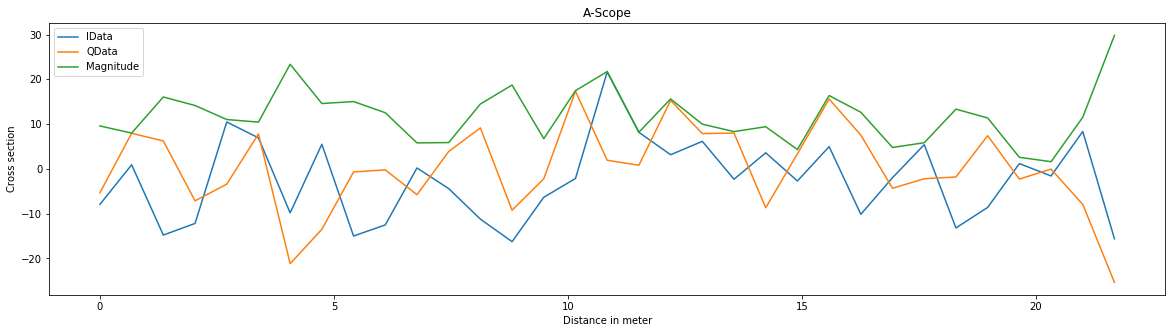

In [15]:
i_fft_real = i_fft.real
q_fft_real = q_fft.real

m_fft_real = np.hypot(i_fft_real, q_fft_real).real
# math.sqrt(i_fft ** 2 + q_fft ** 2)

# the numpy implementation returns also imaginary values, but you can't plot them
# some implementations may strip the imaginary part away. 

plt.figure(figsize=(20,5))
plt.plot(distances, i_fft_real) # x, y
plt.plot(distances, q_fft_real) # x, y
plt.plot(distances, m_fft_real) # x, y
plt.xlabel('Distance in meter')
plt.ylabel('Cross section')
plt.title('A-Scope')
plt.legend(['IData', 'QData', 'Magnitude'])
plt.show()